In [52]:
#default_exp load

# Load data from the longwall

> Methods for loading data

In [53]:
#export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from datetime import datetime, timedelta
from timecluster_hub.utils import *

In [54]:
base_path = Path.home()
base_path

Path('/home/victor')

## Read data from HMB longwall

We will take data from one day of the shearer. the data is hosted at https://aida.ii.uam.es/2018-01-15.csv

In [55]:
#!wget -O /data/input_data.csv https://aida.ii.uam.es/2018-01-06.csv

In [56]:
data = pd.read_csv(base_path/'data/PACMEL-2019/343_HMB/2018-01-06.csv', sep=';', skiprows=2)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (18,19,20,21,22,23,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
data.head()

,description,Prąd silnika organu lewego,Prąd silnika organu prawego,Prąd lewego silnika posuwu,Prąd prawego silnika posuwu,Temperatura łożysko – silnik organu prawego,Temperatura uzwojenie – silnik organu prawego,Temperatura łożysko – silnik organu lewego,Temperatura uzwojenie – silnik organu lewego,Temperatura łożysko – silnik ciągnika lewego,...,Doziemienie.8,Napęd górny PZS bieg wolny,Załączenie.9,Prąd.9,Zabezpieczenie.9,Przeciążenie.9,Zwarcie.9,Temperatura.9,Doziemienie.9,Unnamed: 176
0,2018-01-06 00:00:00,0.0,0.0,0.0,0.0,53.0,54.0,54.0,62.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-06 00:00:01,0.0,0.0,0.0,0.0,53.0,54.0,53.0,62.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-06 00:00:02,0.0,0.0,0.0,0.0,53.0,54.0,53.0,62.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-06 00:00:03,0.0,0.0,0.0,0.0,53.0,54.0,53.0,63.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-06 00:00:04,0.0,0.0,0.0,0.0,53.0,54.0,53.0,63.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Columns: 177 entries, description to Unnamed: 176
dtypes: float64(122), int64(1), object(54)
memory usage: 116.7+ MB


The timestamp is given in the column `description`

In [59]:
data['timestamp'] = pd.to_datetime(data['description'])
data = data.drop('description', axis=1)

In [60]:
df1 = data.select_dtypes(exclude='object')
df2 = data.select_dtypes(include='object').astype('bool')
data = pd.concat([df2.reset_index(drop = True), df1], axis = 1)

For the dimensionality reduction we might be interested only in the numeric columns

In [61]:
data_numeric = data.select_dtypes(include=['float', 'datetime'])

As detailed in the TimeCluster paper, the data will be normalized into the range $[0, 1]$. Also, NaN columsn will be removed.

In [62]:
tmp = data_numeric.select_dtypes(include='float')
#data_numeric[data_numeric.select_dtypes(include='float')] = (tmp - tmp.min())/(tmp.max()-tmp.min())
data_numeric[data_numeric.select_dtypes(include='float').columns] = (tmp - tmp.min())/(tmp.max()-tmp.min())

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [63]:
data_numeric = data_numeric.dropna(axis=1, how='all').fillna(0)

Finally, we define a function that gathers all this operations

In [64]:
#export
def fpreprocess_numeric_vars(data, cname_ts=None, normalize=True, nan_replacement=0):
    "Preprocess a dataframe `data` containing the monitoring data from a mining longwall. \
    Non-numeric variables will be removed. Each column \
    is expected to have values of a variable in form of a time series, whose index will be described in the \
    column named `cname_ts`. If `cname_ts` is None (default), the index of the dataframe is assumed to contain the \
    timestamps. .NaN values will be \
    replaced by a constant value `nan_replacement`"
    if cname_ts is not None:
        data.index = pd.to_datetime(data[cname_ts])
        data = data.drop(cname_ts, axis=1)
    df1 = data.select_dtypes(exclude='object')
    df2 = data.select_dtypes(include='object').astype('bool')
    data = pd.concat([df2, df1], axis = 1)
    data_numeric = data.select_dtypes(include=['float', 'datetime'])
    tmp = data_numeric.select_dtypes(include='float')
    if normalize: data_numeric[data_numeric.select_dtypes(include='float').columns] = (tmp - tmp.min())/(tmp.max()-tmp.min())
    data_numeric = data_numeric.dropna(axis=1, how='all').fillna(nan_replacement)
    return data_numeric

In [65]:
path = Path(base_path/'data/PACMEL-2019/JNK/jnk_before_handling_missing.pickle')

In [66]:
df = None
with open(path, 'rb') as f:
    bin_data = f.read()
    df = pickle.loads(bin_data)[0]

In [67]:
preprocessed_df = fpreprocess_numeric_vars(data=df)

<AxesSubplot:xlabel='TIMESTAMP'>

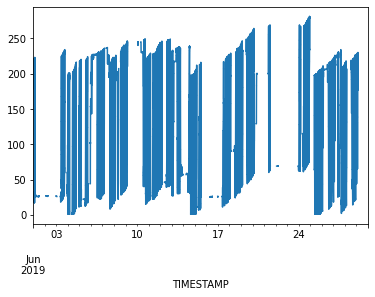

In [68]:
df.SM_ShearerLocation.plot()

<AxesSubplot:xlabel='TIMESTAMP'>

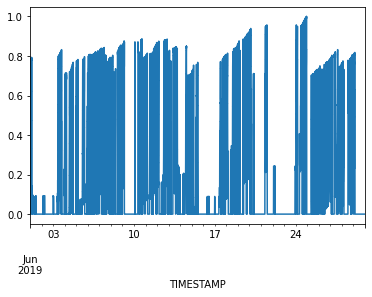

In [69]:
preprocessed_df.SM_ShearerLocation.plot()

## Read multiple monitoring files, given as daily CSVs

Since the mining monitoring data is given a set of CSV files, one per day, it is usefl to have a function to load multiple files in order to analyse data from multiple days

In [70]:
#export
def fread_and_concat(paths, **read_args):
    "Read, from `paths`, a list of mining dataframes and concat them. All dataframes \
    must have the same columns. "
    return pd.concat([pd.read_csv(x, **read_args) for x in paths],
                     ignore_index=True)

In [71]:
paths = [base_path/'data/PACMEL-2019/343_HMB/2018-01-14.csv', base_path/'data/PACMEL-2019/343_HMB/2018-01-15.csv']
df1 = pd.read_csv(paths[0], sep=';', skiprows=2, nrows=3)
df2 = pd.read_csv(paths[1], sep=';', skiprows=2, nrows=3)
df = fread_and_concat(paths, sep=';', skiprows=2, nrows=3)

In [72]:
test_eq(df1.shape[0] + df2.shape[0], df.shape[0])
all_equal([df1.shape[1], df2.shape[1], df.shape[1]], np.repeat(df1.shape[1], 3))

True

In [73]:
#export
def fread_mining_monitoring_files(paths, **kwargs):
    "Read monitoring files from the PACMEL mining use case."
    df = fread_and_concat(paths,
                          sep=';',
                          low_memory=False,
                          skiprows=2,
                          **kwargs)
    # Convert the timestamp column into a proper datetime object
    df['description'] = pd.to_datetime(df['description'])
    return df

In [74]:
paths = [base_path/'data/PACMEL-2019/343_HMB/2018-01-14.csv', base_path/'data/PACMEL-2019/343_HMB/2018-01-15.csv']
df = fread_mining_monitoring_files(paths, nrows=3)

In [75]:
isinstance(df, pd.core.frame.DataFrame)

True

## Time series artifacts (to be used with weights and biases)

This class is meant to extend `wandb.Artifact` for logging/using files with time series data.

In [76]:
#export
class TSArtifact(wandb.Artifact):
    
    default_storage_path = Path(Path.home()/'data/wandb_artifacts/')
    date_format = '%Y-%m-%d %H:%M:%S' # TODO add milliseconds
    handle_missing_values_techniques = {
        'linear_interpolation': lambda df : df.interpolate(method='linear', limit_direction='both'),
        'overall_mean': lambda df : df.fillna(df.mean()),
        'overall_median': lambda df : df.fillna(df.median())
    }

    "Class that represents a wandb artifact containing time series data. sd stands for start_date \
    and ed for end_date. Both should be pd.Timestamps"
    
    @delegates(wandb.Artifact.__init__)
    def __init__(self, name, sd:pd.Timestamp, ed:pd.Timestamp, **kwargs):
        super().__init__(type='dataset', name=name, **kwargs)
        self.sd = sd
        self.ed = ed
        if self.metadata is None:
            self.metadata = dict()
        self.metadata['TS'] = dict(sd = self.sd.strftime(self.date_format),
                                   ed = self.ed.strftime(self.date_format))

        
    @classmethod
    def from_daily_csv_files(cls, root_path, fread=pd.read_csv, start_date=None, end_date=None, metadata=None, **kwargs):
        
        "Create a wandb artifact of type `dataset`, containing the CSV files from `start_date` \
        to `end_date`. Dates must be pased as `datetime.datetime` objects. If a `wandb_run` is \
        defined, the created artifact will be logged to that run, using the longwall name as \
        artifact name, and the date range as version."
        
        return None

    
    @classmethod
    @delegates(__init__)
    def from_df(cls, df:pd.DataFrame, name:str, path:str=None, sd:pd.Timestamp=None, ed:pd.Timestamp=None,
                normalize:bool=False, missing_values_technique:str=None, resampling_freq:str=None, **kwargs):
        
        """
        Create a TSArtifact of type `dataset`, using the DataFrame `df` samples from \
        `sd` (start date) to `ed` (end date). Dates must be passed as `datetime.datetime` \
        objects. The transformed DataFrame is stored as a pickle file in the path `path` \
        and its reference is added to the artifact entries. Additionally, the dataset can \
        be normalized (see `normalize` argument) or transformed using missing values \
        handling techniques (see `missing_values_technique` argument) or resampling (see \
        `resampling_freq` argument).
        
        Arguments:
            df: (DataFrame) The dataframe you want to convert into an artifact.
            name: (str) The artifact name.
            path: (str, optional) The path where the file, containing the new transformed \
                dataframe, is saved. Default None.
            sd: (sd, optional) Start date. By default, the first index of `df` is taken.
            ed: (ed, optional) End date. By default, the last index of `df` is taken.
            normalize: (bool, optional) If the dataset values should be normalized. Default\
                False.
            missing_values_technique: (str, optional) The technique used to handle missing \
                values. Options: "linear_iterpolation", "overall_mean", "overall_median" or \
                None. Default None.
            resampling_freq: (str, optional) The offset string or object representing \
                frequency conversion for time series resampling. Default None.
                
        Returns: 
            TSArtifact object.
        """
        # Indexing and Resampling
        if not isinstance(df.index, pd.DatetimeIndex):
            # Create fake timestamps, keeping the resampling frequency if it has
            # been established
            timedelta = pd.to_timedelta(ifnone(resampling_freq, 1), 
                                        unit='s' if resampling_freq is None else None)
            df.index = pd.to_datetime(0) + timedelta*df.index
        if resampling_freq: df = df.resample(resampling_freq).mean()
        else: df.index.freq = '1s'
        
        sd = df.index[0] if sd is None else sd
        ed = df.index[-1] if ed is None else ed
        obj = cls(name, sd=sd, ed=ed, **kwargs)
        df = df.query('@obj.sd <= index <= @obj.ed')
        obj.metadata['TS']['created'] = 'from-df'
        obj.metadata['TS']['n_vars'] = df.columns.__len__()
        
        # Handle Missing Values
        df = obj.handle_missing_values_techniques[missing_values_technique](df) if missing_values_technique is not None else df
        obj.metadata['TS']['handle_missing_values_technique'] = missing_values_technique.__str__()
        obj.metadata['TS']['has_missing_values'] = np.any(df.isna().values).__str__()
        
        # Sampling
        obj.metadata['TS']['n_samples'] = len(df)
        obj.metadata['TS']['freq'] = str(df.index.freq)
        
        # Time Series Variables
        obj.metadata['TS']['vars'] = list(df.columns)
        
        # Normalization - Save the previous means and stds
        if normalize:
            obj.metadata['TS']['normalization'] = dict(means = df.describe().loc['mean'].to_dict(),
                                                       stds = df.describe().loc['std'].to_dict())
            df = normalize_columns(df)
        
        # Hash and save
        hash_code = str(hash(df.values.tobytes()))
        path = obj.default_storage_path/f'{hash_code}' if path is None else Path(path)/f'{hash_code}'
        df.to_pickle(path)
        obj.metadata['TS']['hash'] = hash_code
        obj.add_file(str(path))
        
        return obj

In [77]:
# TSArtifact class TEST

# resampling frequency
resampling_freq = '5s'
# handle missing values technique
missing_values_technique='overall_median'

# testing dataframe
df_test = pd.util.testing.makeMissingDataframe()
df_test.index = pd.date_range(start='2021-01-01', periods=len(df_test), freq='s')

artifact = TSArtifact.from_df(df_test, 
                              name='JNK', 
                              missing_values_technique=missing_values_technique,
                              resampling_freq=resampling_freq, 
                              normalize=True)
artifact.metadata

{'TS': {'sd': '2021-01-01 00:00:00',
  'ed': '2021-01-01 00:00:25',
  'created': 'from-df',
  'n_vars': 4,
  'handle_missing_values_technique': 'overall_median',
  'has_missing_values': 'False',
  'n_samples': 6,
  'freq': '<5 * Seconds>',
  'vars': ['A', 'B', 'C', 'D'],
  'normalization': {'means': {'A': -0.1129979747674985,
    'B': 0.17133948478672947,
    'C': -0.15187400678354243,
    'D': -0.4088419582287755},
   'stds': {'A': 0.5750982907023975,
    'B': 0.4177995100606826,
    'C': 0.22293269881426633,
    'D': 0.5511959251963479}},
  'hash': '-9122869661193101395'}}

At the end, we are interested in working with time series as a dataframe. So we need a function to download the files contained in a `wandb.apis.public.Artifact` object and process them into a TS dataframe. The process of passing from files to dataframe must be different depending on what type of creation method was used to generate the original `TSArtifact`.

In [78]:
#export
@patch
def to_df(self:wandb.apis.public.Artifact):
    "Download the files of a saved wandb artifact and process them as a single dataframe. The artifact must \
    come from a call to `run.use_artifact` with a proper wandb run."
    # The way we have to ensure that the argument comes from a TS arfitact is the metadata
    if self.metadata.get('TS') is None:
        print(f'ERROR:{self} does not come from a logged TSArtifact')
        return None
    dir = Path(self.download())
    if self.metadata['TS']['created'] == 'from-df':
        # Call read_pickle with the single file from dir
        return pd.read_pickle(dir.ls()[0])
    else:
        print("ERROR: Only from_df method is allowed yet")

For convenience, we can write a method to cast a downloaded wandb artifact (instance from `wandb.apis.public,Artifact`) to a TSArtifact

In [79]:
#export
@patch
def to_tsartifact(self:wandb.apis.public.Artifact):
    "Cast an artifact as a TS artifact. The artifact must have been created from one of the \
    class creation methods of the class `TSArtifact`. This is useful to go back to a TSArtifact \
    after downloading an artifact through the wand API"
    return TSArtifact(name=self.digest, #TODO change this
                      sd=pd.to_datetime(self.metadata['TS']['sd'], format=TSArtifact.date_format),
                      ed=pd.to_datetime(self.metadata['TS']['sd'], format=TSArtifact.date_format),
                      description=self.description,
                      metadata=self.metadata)

In [80]:
#export
def create_longwall_data_artifact(root_path, start_date, end_date, longwall_name='Unnamed_longwall', wandb_run=None):
    "Create a wandb artifact of type `dataset`, containing the CSV files from `start_date` \
    to `end_date`. Dates must be pased as `datetime.datetime` objects. If a `wandb_run` is \
    defined, the created artifact will be logged to that run, using the longwall name as \
    artifact name, and the date range as version."
    # Compute the number of variables for the metadata (total and numeric)
    root_path = Path(root_path)
    date_diff = end_date - start_date
    sd_str = start_date.strftime("%Y-%m-%d")
    ed_str = end_date.strftime("%Y-%m-%d")
    mock_data = fread_mining_monitoring_files([f'{root_path/start_date.strftime("%Y-%m-%d")}.csv'],
                                             nrows=1)
    artifact_name = longwall_name if longwall_name else root_path
    artifact = wandb.Artifact(type='dataset',
                              name=artifact_name,
                              description='Dataset from the PACMEL mining use case. It contains \
                              monitoring data from a longwall shearer',
                              metadata={
                              'longwall': longwall_name,
                              'start_time': datetime.strftime(start_date, format='%Y-%m-%d %H:%M:%S'),
                              'end_time': datetime.strftime(end_date, format='%Y-%m-%d %H:%M:%S'),
                              'n_variables': len(mock_data.columns)-1 # Exclude timestamp
                              })
    # ADd files as references (we do not upload files for confidential reasons)
    [artifact.add_reference(f'file://{root_path/x.strftime("%Y-%m-%d")}.csv')
     for x in (start_date + timedelta(days=n) for n in range(date_diff.days + 1))]

    if wandb_run:
        artifact_version = f'{sd_str}_{ed_str}'
        wandb_run.log_artifact(artifact,
                               aliases=['latest', artifact_version])
    return artifact

In [81]:
run = wandb.init(job_type='create_dataset', resume='allow', id='2swfm2i')

In [82]:
sd = datetime.strptime("2018-01-01", "%Y-%m-%d")
ed = sd + timedelta(hours=3)
ar = create_longwall_data_artifact(root_path=base_path/'data/PACMEL-2019/343_HMB', 
                                   start_date=sd, 
                                   end_date=ed,
                                   longwall_name='HMB', 
                                   wandb_run=run)
ar

Try to use the logged artifact

In [83]:
ar_recovered = run.use_artifact('HMB:latest', type='dataset')

In [84]:
dir = Path(ar_recovered.download())

In [85]:
retrieved_data = fread_mining_monitoring_files(dir.ls(), nrows=3)

In [86]:
retrieved_data.shape

(3, 177)

### Load longwall data artifact

This function is quite handy to turn the contents of a longwall artifact, created with the function `create_longwall_data_artifact`. This is specially useful in the case where the monitoring files are given in a daily basis, but you are only interested in analysing a couple of hours of data. In that case, the artifact will link the whole day file, but using the metadata, this function will only read the corresponding  

In [87]:
#export
# TODO: Tiene que haber un error si el start date pasado es menor que el inicio del primer fichero, y lo mismo con el end date final
def load_longwall_data_artifact(a:wandb.Artifact):
    "Returns a dataframe with the longwall data, subsetted by the artifact metadata"
    a_refs = [x.ref for x in a.manifest.entries.values()]
    data = fread_mining_monitoring_files(a_refs)
    sd = datetime.strptime(a.metadata['start_time'], '%Y-%m-%d %H:%M:%S')
    ed = datetime.strptime(a.metadata['end_time'], '%Y-%m-%d %H:%M:%S')
    data = data.query('description >= @sd and description <= @ed')
    return data

In [88]:
paths = [base_path/'data/PACMEL-2019/343_HMB/2018-01-01.csv']

In [89]:
df = fread_mining_monitoring_files(paths, nrows=1000)

In [90]:
start_date = df['description'][0]
end_date = start_date + timedelta(minutes=15)
start_date, end_date

(Timestamp('2018-01-01 05:00:00'), Timestamp('2018-01-01 05:15:00'))

In [91]:
a = create_longwall_data_artifact(root_path=base_path/'data/PACMEL-2019/343_HMB/', 
                                  start_date=start_date, 
                                  end_date=start_date + timedelta(minutes=15), 
                                  wandb_run=None)

In [92]:
df_subset = load_longwall_data_artifact(a)

In [93]:
test_eq(df.columns, df_subset.columns) 

In [94]:
test_eq(df_subset['description'][0], start_date)

In [95]:
test_eq(df_subset['description'][len(df_subset['description']) -1], end_date)

## Export -

In [96]:
#hide
from nbdev.export import *
notebook2script()

Converted 01_dataset_artifact.ipynb.
Converted 02a_encoder_DCAE-torch.ipynb.
Converted 02a_encoder_DCAE.ipynb.
Converted 02b_encoder_MVP.ipynb.
Converted 03_dimensionality_reduction.ipynb.
Converted 04_baseline_models.ipynb.
Converted index.ipynb.
Converted load.ipynb.
Converted utils.ipynb.
Converted visualization.ipynb.
